In [1]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGSMITH_API_KEY")
os.environ["LANGSMITH_PROJECT"] = "langgraph_multiagent"
os.environ["LANGSMTIH_TRACING"] = "true"

In [2]:
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import PyMuPDFLoader

directory_loader = DirectoryLoader("data", glob="**/*.pdf", loader_cls=PyMuPDFLoader)

loan_knowledge_resources = directory_loader.load()

In [3]:
import tiktoken
from langchain.text_splitter import RecursiveCharacterTextSplitter

def tiktoken_len(text):
    tokens = tiktoken.encoding_for_model("gpt-4o").encode(
        text,
    )
    return len(tokens)

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 750,
    chunk_overlap = 0,
    length_function = tiktoken_len,
)

loan_knowledge_chunks = text_splitter.split_documents(loan_knowledge_resources)

In [4]:
len(loan_knowledge_chunks)

375

In [5]:
from langchain_openai.embeddings import OpenAIEmbeddings

embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")

In [6]:
from langchain_community.vectorstores import Qdrant

qdrant_vectorstore = Qdrant.from_documents(
    documents=loan_knowledge_chunks,
    embedding=embedding_model,
    location=":memory:"
)

In [7]:
qdrant_retriever = qdrant_vectorstore.as_retriever()

In [8]:
from langchain_core.prompts import ChatPromptTemplate

HUMAN_TEMPLATE = """
#CONTEXT:
{context}

QUERY:
{query}

Use the provide context to answer the provided user query. Only use the provided context to answer the query. If you do not know the answer, or it's not contained in the provided context respond with "I don't know"
"""

chat_prompt = ChatPromptTemplate.from_messages([
    ("human", HUMAN_TEMPLATE)
])

In [9]:
from langchain_openai import ChatOpenAI

openai_chat_model = ChatOpenAI(model="gpt-4.1-nano")

In [10]:
from langgraph.graph import START, StateGraph
from typing_extensions import TypedDict
from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser

class State(TypedDict):
  question: str
  context: list[Document]
  response: str

def retrieve(state: State) -> State:
  retrieved_docs = qdrant_retriever.invoke(state["question"])
  return {"context" : retrieved_docs}

def generate(state: State) -> State:
  generator_chain = chat_prompt | openai_chat_model | StrOutputParser()
  response = generator_chain.invoke({"query" : state["question"], "context" : state["context"]})
  return {"response" : response}

graph_builder = StateGraph(State)
graph_builder = graph_builder.add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
rag_graph = graph_builder.compile()

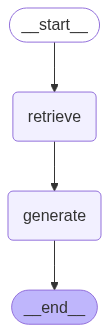

In [11]:
rag_graph

In [12]:
rag_graph.invoke({"question" : "What is the maximum loan amount?"})

{'question': 'What is the maximum loan amount?',
 'context': [Document(metadata={'producer': 'GPL Ghostscript 10.00.0', 'creator': 'wkhtmltopdf 0.12.6', 'creationdate': "D:20250605165703Z00'00'", 'source': 'data/The_Direct_Loan_Program.pdf', 'file_path': 'data/The_Direct_Loan_Program.pdf', 'total_pages': 71, 'format': 'PDF 1.7', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'moddate': "D:20250605165703Z00'00'", 'trapped': '', 'modDate': "D:20250605165703Z00'00'", 'creationDate': "D:20250605165703Z00'00'", 'page': 69, '_id': '1ce2ec2bc9a0491db778f7229ababc93', '_collection_name': 'cb91bea95db54b57bce6ccfc8864a78a'}, page_content='program. Therefore, the maximum loan amount the student may receive for the program at School B (for the\nabbreviated loan period and any subsequent loan period combined) is a total of $1,815, not more than $1,155 of\nwhich may be subsidized (the prorated loan limits for the program). If the student receives the maximum prorated\nloan limit for the 

In [13]:
from typing import Any, Callable, List, Optional, TypedDict, Union

from langchain.agents import AgentExecutor, create_openai_functions_agent
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.runnables import Runnable
from langchain_core.tools import BaseTool
from langchain_openai import ChatOpenAI

from langgraph.graph import END, StateGraph

In [14]:
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

In [15]:
def create_agent(
    llm: ChatOpenAI,
    tools: list,
    system_prompt: str,
) -> str:
    """Create a function-calling agent and add it to the graph."""
    system_prompt += ("\nWork autonomously according to your specialty, using the tools available to you."
    " Do not ask for clarification."
    " Your other team members (and other teams) will collaborate with you with their own specialties."
    " You are chosen for a reason!")
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_functions_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

In [16]:
def create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:
    """An LLM-based router."""
    options = ["FINISH"] + members
    function_def = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ],
                },
            },
            "required": ["next"],
        },
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    return (
        prompt
        | llm.bind_functions(functions=[function_def], function_call="route")
        | JsonOutputFunctionsParser()
    )

In [17]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_tool = TavilySearchResults(max_results=5)

/tmp/ipykernel_25850/1911882425.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_tool = TavilySearchResults(max_results=5)


In [18]:
from typing import Annotated, List, Tuple, Union
from langchain_core.tools import tool

@tool
def retrieve_information(
    query: Annotated[str, "query to ask the retrieve information tool"]
    ):
  """Use Retrieval Augmented Generation to retrieve information about student loan policies"""
  return rag_graph.invoke({"question" : query})

In [19]:
import functools
import operator

from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI
import functools

class ResearchTeamState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    team_members: List[str]
    next: str

In [20]:
llm = ChatOpenAI(model="gpt-4o-mini")

In [21]:
search_agent = create_agent(
    llm,
    [tavily_tool],
    "You are a research assistant who can search for up-to-date info using the tavily search engine.",
)
search_node = functools.partial(agent_node, agent=search_agent, name="Search")

In [22]:
research_agent = create_agent(
    llm,
    [retrieve_information],
    "You are a research assistant who can provide specific information on the student loan policies",
)
research_node = functools.partial(agent_node, agent=research_agent, name="LoanRetriever")

In [23]:
supervisor_agent = create_team_supervisor(
    llm,
    ("You are a supervisor tasked with managing a conversation between the"
    " following workers:  Search, LoanRetriever. Given the following user request,"
    " determine the subject to be researched and respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. "
    " You should never ask your team to do anything beyond research. They are not required to write content or posts."
    " You should only pass tasks to workers that are specifically research focused."
    " When finished, respond with FINISH."),
    ["Search", "LoanRetriever"],
)

/tmp/ipykernel_25850/488856706.py:34: LangChainDeprecationWarning: The method `BaseChatOpenAI.bind_functions` was deprecated in langchain-openai 0.2.1 and will be removed in 1.0.0. Use :meth:`~langchain_openai.chat_models.base.ChatOpenAI.bind_tools` instead.
  | llm.bind_functions(functions=[function_def], function_call="route")


In [24]:
research_graph = StateGraph(ResearchTeamState)

research_graph.add_node("Search", search_node)
research_graph.add_node("LoanRetriever", research_node)
research_graph.add_node("supervisor", supervisor_agent)

In [25]:
research_graph.add_edge("Search", "supervisor")
research_graph.add_edge("LoanRetriever", "supervisor")
research_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {"Search": "Search", "LoanRetriever": "LoanRetriever", "FINISH": END},
)

In [26]:
research_graph.set_entry_point("supervisor")
compiled_research_graph = research_graph.compile()

In [27]:
import nest_asyncio
nest_asyncio.apply()

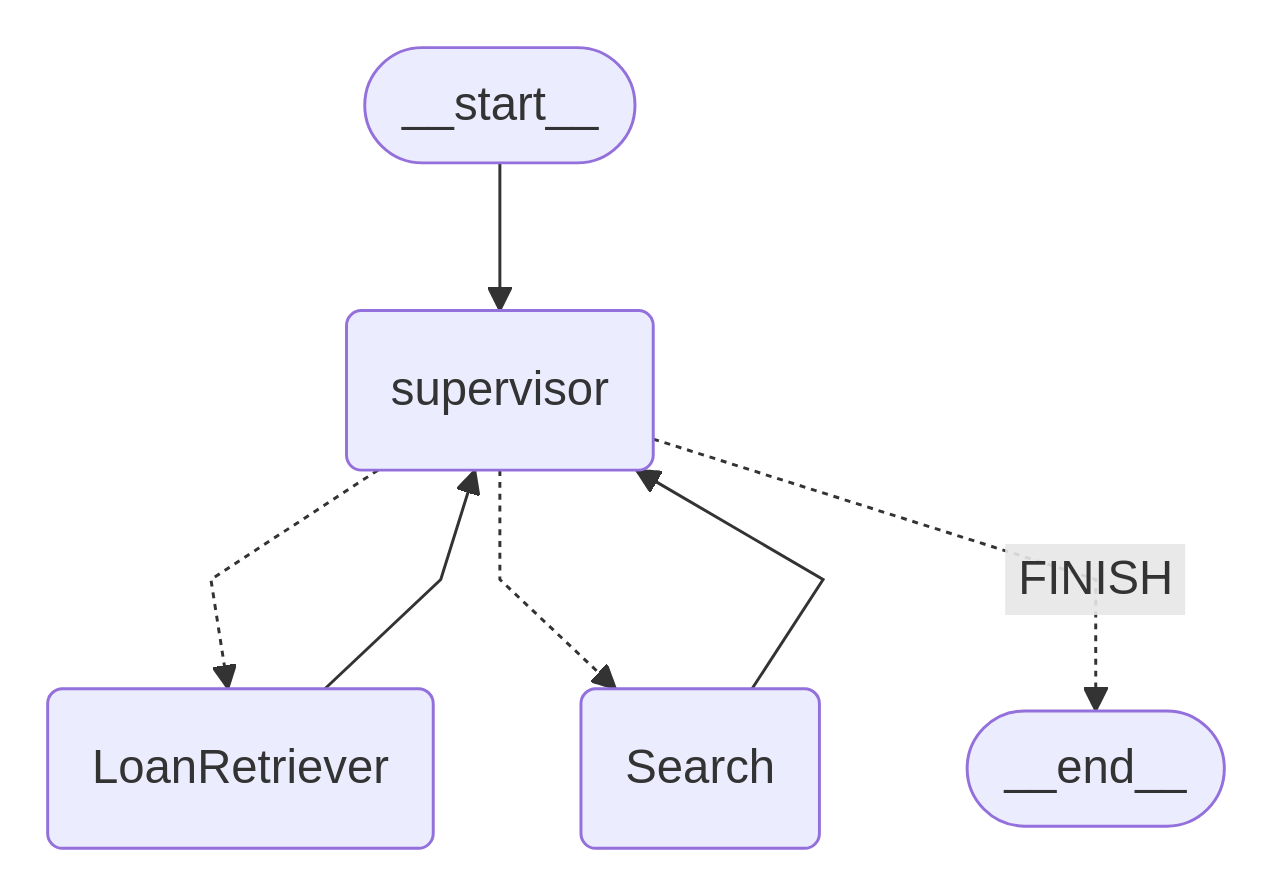

In [28]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        compiled_research_graph.get_graph().draw_mermaid_png(
            curve_style=CurveStyle.LINEAR,
            node_colors=NodeStyles(first="#ffdfba", last="#baffc9", default="#fad7de"),
            wrap_label_n_words=9,
            output_file_path=None,
            draw_method=MermaidDrawMethod.PYPPETEER,
            background_color="white",
            padding=10,
        )
    )
)

In [29]:
def enter_chain(message: str):
    results = {
        "messages": [HumanMessage(content=message)],
    }
    return results

research_chain = enter_chain | compiled_research_graph

In [30]:
for s in research_chain.stream(
    "What is the maximum student loan in 2025?", {"recursion_limit": 100}
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'LoanRetriever'}}
---
{'LoanRetriever': {'messages': [HumanMessage(content="The maximum student loan amounts for 2025 vary based on the student's status:\n\n- **Dependent Undergraduates** (excluding those whose parents can't obtain Direct PLUS Loans):\n  - Total maximum (subsidized and unsubsidized): **$31,000**\n  - Maximum subsidized portion: **$23,000**\n\n- **Independent Undergraduates** (and dependent undergraduates whose parents cannot get Direct PLUS Loans):\n  - Total maximum: **$57,500**\n  - Maximum subsidized portion: **$23,000**\n\n- **Graduate and Professional Students**:\n  - Total maximum: **$138,500**\n  - Maximum subsidized portion: **$65,500**\n\nThese limits include any loans received for prior undergraduate study and are subject to aggregate limits based on the student's educational history and loan type.", additional_kwargs={}, response_metadata={}, name='LoanRetriever')]}}
---
{'supervisor': {'next': 'FINISH'}}
---


In [31]:

from langchain_community.document_loaders import CSVLoader

complaint_loader = CSVLoader("data/complaints.csv", content_columns=["Consumer complaint narrative", "Company public response", "Company response to consumer"])
complaints = complaint_loader.load()
complaints[0]

Document(metadata={'source': 'data/complaints.csv', 'row': 0}, page_content="Consumer complaint narrative: The federal student loan COVID-19 forbearance program ended in XX/XX/XXXX. However, payments were not re-amortized on my federal student loans currently serviced by Nelnet until very recently. The new payment amount that is effective starting with the XX/XX/XXXX payment will nearly double my payment from {$180.00} per month to {$360.00} per month. I'm fortunate that my current financial position allows me to be able to handle the increased payment amount, but I am sure there are likely many borrowers who are not in the same position. The re-amortization should have occurred once the forbearance ended to reduce the impact to borrowers.\nCompany public response: None\nCompany response to consumer: Closed with explanation")

In [32]:
qdrant_complaint_vectorstore = Qdrant.from_documents(
    documents=complaints,
    embedding=embedding_model,
    location=":memory:"
)

In [33]:
qdrant_complaint_retriever = qdrant_complaint_vectorstore.as_retriever()

In [34]:
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional
from typing_extensions import TypedDict
import uuid
import os

os.makedirs('./content/data', exist_ok=True)

def create_random_subdirectory():
    random_id = str(uuid.uuid4())[:8]  # Use first 8 characters of a UUID
    subdirectory_path = os.path.join('./content/data', random_id)
    os.makedirs(subdirectory_path, exist_ok=True)
    return subdirectory_path

WORKING_DIRECTORY = Path(create_random_subdirectory())

@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"


@tool
def read_document(
    file_name: Annotated[str, "File path to save the document."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is not None:
        start = 0
    return "\n".join(lines[start:end])


@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"

@tool 
def reference_previous_responses(
    query: Annotated[str, "The query to search for in the previous responses."],
) -> Annotated[str, "The previous responses that match the query."]:
    """Search for previous responses that match the query."""
    return qdrant_complaint_retriever.invoke(query)


@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ] = {},
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"

In [35]:
import operator
from pathlib import Path

class DocWritingState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    team_members: str
    next: str
    current_files: str

In [36]:
def prelude(state):
    written_files = []
    if not WORKING_DIRECTORY.exists():
        WORKING_DIRECTORY.mkdir()
    try:
        written_files = [
            f.relative_to(WORKING_DIRECTORY) for f in WORKING_DIRECTORY.rglob("*")
        ]
    except:
        pass
    if not written_files:
        return {**state, "current_files": "No files written."}
    return {
        **state,
        "current_files": "\nBelow are files your team has written to the directory:\n"
        + "\n".join([f" - {f}" for f in written_files]),
    }

In [38]:
doc_writer_agent = create_agent(
    llm,
    [write_document, edit_document, read_document],
    ("You are an expert writing customer assistance responses.\n"
    "Below are files currently in your directory:\n{current_files}"),
)
context_aware_doc_writer_agent = prelude | doc_writer_agent
doc_writing_node = functools.partial(
    agent_node, agent=context_aware_doc_writer_agent, name="DocWriter"
)

note_taking_agent = create_agent(
    llm,
    [create_outline, read_document, reference_previous_responses],
    ("You are an expert senior researcher tasked with writing a customer assistance outline and"
    " taking notes to craft a customer assistance response.\n{current_files}"),
)
context_aware_note_taking_agent = prelude | note_taking_agent
note_taking_node = functools.partial(
    agent_node, agent=context_aware_note_taking_agent, name="NoteTaker"
)

copy_editor_agent = create_agent(
    llm,
    [write_document, edit_document, read_document],
    ("You are an expert copy editor who focuses on fixing grammar, spelling, and tone issues\n"
    "Below are files currently in your directory:\n{current_files}"),
)
context_aware_copy_editor_agent = prelude | copy_editor_agent
copy_editing_node = functools.partial(
    agent_node, agent=context_aware_copy_editor_agent, name="CopyEditor"
)

dopeness_editor_agent = create_agent(
    llm,
    [write_document, edit_document, read_document],
    ("You are an expert in dopeness, litness, coolness, etc - you edit the document to make sure it's dope. Make sure to use a number of emojis."
    "Below are files currently in your directory:\n{current_files}"),
)
context_aware_dopeness_editor_agent = prelude | dopeness_editor_agent
dopeness_node = functools.partial(
    agent_node, agent=context_aware_dopeness_editor_agent, name="DopenessEditor"
)

doc_writing_supervisor = create_team_supervisor(
    llm,
    ("You are a supervisor tasked with managing a conversation between the"
    " following workers: {team_members}. You should always verify the technical"
    " contents after any edits are made. "
    "Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When each team is finished,"
    " you must respond with FINISH."),
    ["DocWriter", "NoteTaker", "DopenessEditor", "CopyEditor"],
)

In [39]:
authoring_graph = StateGraph(DocWritingState)
authoring_graph.add_node("DocWriter", doc_writing_node)
authoring_graph.add_node("NoteTaker", note_taking_node)
authoring_graph.add_node("CopyEditor", copy_editing_node)
authoring_graph.add_node("DopenessEditor", dopeness_node)
authoring_graph.add_node("supervisor", doc_writing_supervisor)

authoring_graph.add_edge("DocWriter", "supervisor")
authoring_graph.add_edge("NoteTaker", "supervisor")
authoring_graph.add_edge("CopyEditor", "supervisor")
authoring_graph.add_edge("DopenessEditor", "supervisor")

authoring_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "DocWriter": "DocWriter",
        "NoteTaker": "NoteTaker",
        "CopyEditor" : "CopyEditor",
        "DopenessEditor" : "DopenessEditor",
        "FINISH": END,
    },
)

authoring_graph.set_entry_point("supervisor")
compiled_authoring_graph = authoring_graph.compile()

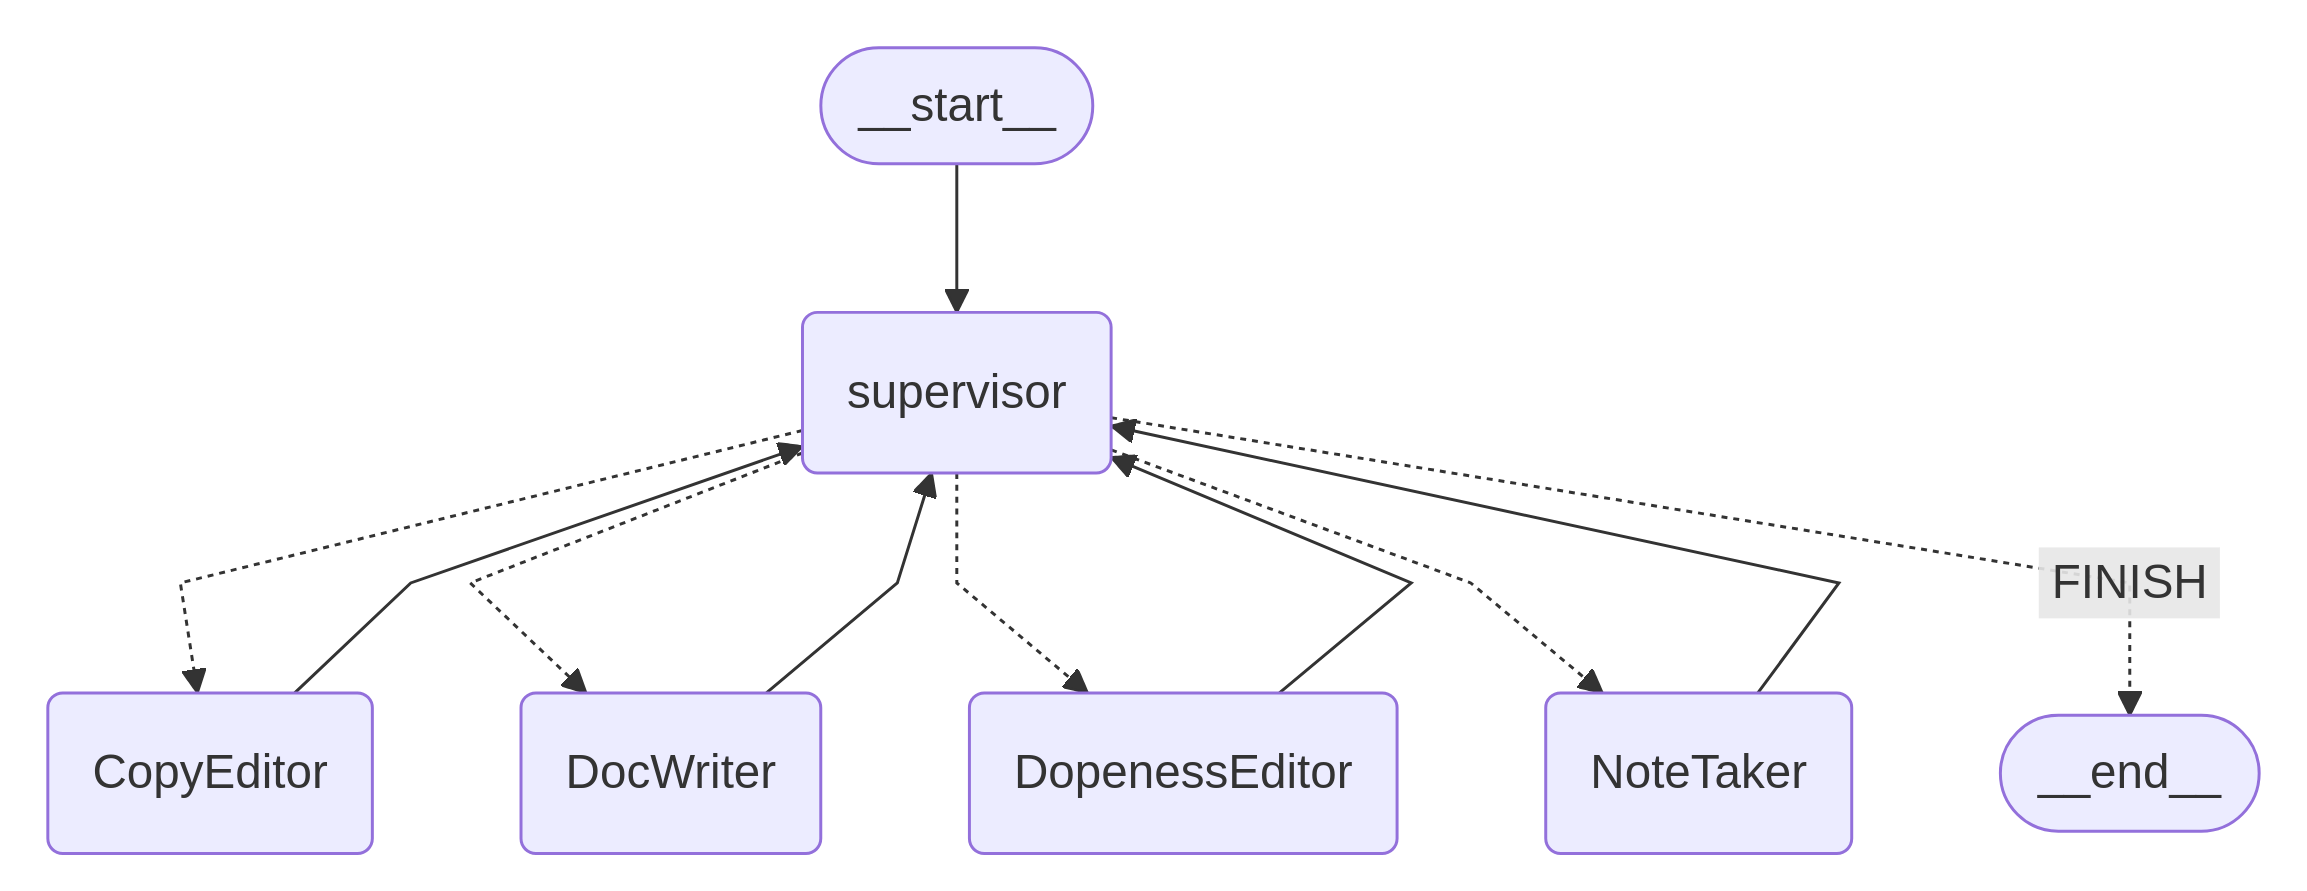

In [40]:
from IPython.display import Image, display

display(
    Image(
        compiled_authoring_graph.get_graph().draw_mermaid_png(
            curve_style=CurveStyle.LINEAR,
            node_colors=NodeStyles(first="#ffdfba", last="#baffc9", default="#fad7de"),
            wrap_label_n_words=9,
            output_file_path=None,
            draw_method=MermaidDrawMethod.PYPPETEER,
            background_color="white",
            padding=10,
        )
    )
)

In [41]:
def enter_chain(message: str, members: List[str]):
    results = {
        "messages": [HumanMessage(content=message)],
        "team_members": ", ".join(members),
    }
    return results

authoring_chain = (
    functools.partial(enter_chain, members=authoring_graph.nodes)
    | authoring_graph.compile()
)

In [42]:
for s in authoring_chain.stream(
    "Write a customer assistance response on the positioning of Student Loans as it relates to low income students.",
    {"recursion_limit": 100},
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'DocWriter'}}
---
{'DocWriter': {'messages': [HumanMessage(content='I have created a customer assistance response regarding the positioning of student loans as it relates to low-income students. The document is titled "Student_Loans_Low_Income_Students_Response.txt". If you need any further edits or additional information, feel free to let me know!', additional_kwargs={}, response_metadata={}, name='DocWriter')]}}
---
{'supervisor': {'next': 'NoteTaker'}}
---
{'NoteTaker': {'messages': [HumanMessage(content="### Customer Assistance Response on Student Loans for Low-Income Students\n\n**Subject: Understanding Student Loans for Low-Income Students**\n\nDear [Customer's Name],\n\nThank you for reaching out to us regarding student loans and their implications for low-income students. We understand that navigating the financial landscape of higher education can be overwhelming, especially for those with limited financial resources.\n\nStudent loans play a critical ro

In [43]:
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

supervisor_node = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following teams: {team_members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When all workers are finished,"
    " you must respond with FINISH.",
    ["Research team", "Response team"],
)

In [44]:
class State(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    next: str

def get_last_message(state: State) -> str:
    return state["messages"][-1].content

def join_graph(response: dict):
    return {"messages": [response["messages"][-1]]}

In [45]:
super_graph = StateGraph(State)

super_graph.add_node("Research team", get_last_message | research_chain | join_graph)
super_graph.add_node("Response team", get_last_message | authoring_chain | join_graph)
super_graph.add_node("supervisor", supervisor_node)

In [46]:
super_graph.add_edge("Research team", "supervisor")
super_graph.add_edge("Response team", "supervisor")
super_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "Response team": "Response team",
        "Research team": "Research team",
        "FINISH": END,
    },
)
super_graph.set_entry_point("supervisor")
compiled_super_graph = super_graph.compile()

In [47]:
WORKING_DIRECTORY = Path(create_random_subdirectory())

for s in compiled_super_graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Write a customer assistance response on the positioning of Student Loans as it relates to low income students. First consult the research team. Then make sure you consult the response team, and check for copy editing and dopeness, and write the file to disk."
            )
        ],
    },
    {"recursion_limit": 30},
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'Research team'}}
---
{'Research team': {'messages': [HumanMessage(content="The response has been crafted carefully and adheres to the guidelines necessary for addressing concerns related to student loans for low-income students. Here is the finalized customer assistance response:\n\n---\n\n**Customer Assistance Response on Student Loans and Low-Income Students**\n\n---\n\nDear [Customer's Name],\n\nThank you for reaching out with your inquiry concerning the positioning of student loans as they relate to low-income students. This is an important topic, and we appreciate your interest in understanding how student loans can impact educational access and financial management for students from low-income backgrounds.\n\n### Overview of Student Loans for Low-Income Students\n\nStudent loans have long been a crucial mechanism for facilitating higher education access, particularly for low-income students who may not have the financial resources to afford tuition, fees,